<a href="https://colab.research.google.com/github/Barissdal/Customer_lifetime_value/blob/main/CLTV_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 5.5 MB/s 


In [3]:
#Reading Data from Excel

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

df_ = pd.read_excel("/content/drive/MyDrive/resource/online_retail_II.xlsx",sheet_name="Year 2010-2011")

df = df_.copy()

In [ ]:
#Reading Data from Database

from sqlalchemy import create_engine

# Credentials
creds = {
    "user" : "*******",
    "passwd" : "******",
    "host" : "******",
    "port" : ******,
    "db" : "*****"
}

# MySQL conection string.
connstr = 'mysql+mysqlconnector://{user}:{passwd}@{host}:{port}/{db}'

# sqlalchemy engine for MySQL connection.
conn = create_engine(connstr.format(**creds))
# conn.close()

pd.read_sql_query("show databases;", conn)
pd.read_sql_query("show tables", conn)

retail_mysql_df = pd.read_sql_query("select * from online_retail_2010_2011 limit 10", conn)

retail_mysql_df.shape
retail_mysql_df.head()
retail_mysql_df.info()

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [ ]:
df.shape

(541910, 8)

In [6]:
# Eksik gözlemlerin silinmesi
df.dropna(inplace=True)

In [7]:
# İade edilen ürünlerin silinmesi
df = df[~df["Invoice"].str.contains("C", na=False)]

In [8]:
#Quantity ve Price değerlerinde 0dan küçük olanların silinmesi

df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]

In [9]:
#TotalPrice değişkenin hesaplanması

df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397885 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  object        
 1   StockCode    397885 non-null  object        
 2   Description  397885 non-null  object        
 3   Quantity     397885 non-null  int64         
 4   InvoiceDate  397885 non-null  datetime64[ns]
 5   Price        397885 non-null  float64       
 6   Customer ID  397885 non-null  float64       
 7   Country      397885 non-null  object        
 8   TotalPrice   397885 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [ ]:
Duplicates

In [10]:
df.duplicated().sum()

5192

In [11]:
# duplicate satırları bulalım

duplicates = df[df.duplicated()]

In [ ]:
duplicates[:20]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95
587,536412,22273,FELTCRAFT DOLL MOLLY,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2010-12-01 11:49:00,3.75,17920.0,United Kingdom,3.75
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,2010-12-01 11:49:00,2.10,17920.0,United Kingdom,2.10
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom,1.65
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,2010-12-01 11:49:00,3.75,17920.0,United Kingdom,7.50


In [ ]:
# It seems that products, which were bought together in one invoice, were considered as duplicates. However, there are no duplicates, if we look at the Description column

In [ ]:
# Dublicate olsaydı aşağıdaki sorgu ile silerdik

# df.drop_duplicates(subset=['hangi değişkene göre', 'hangi değişkene göre'], keep=False, inplace=True)

In [ ]:
Number of unique customers

In [12]:
df['Invoice'].nunique()

18532

In [ ]:
df["Customer ID"].nunique()

4338

In [ ]:
Priod of time

In [ ]:
df["InvoiceDate"].min()

Timestamp('2010-12-01 08:26:00')

In [ ]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
Country

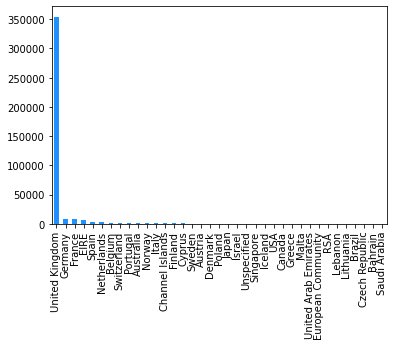

In [ ]:
df["Country"].value_counts().plot.bar(color="dodgerblue")

In [ ]:
df['Country'].nunique()

37

In [ ]:
Quantity and unit price of the products

Text(0.5, 1.0, 'Total price distribution')

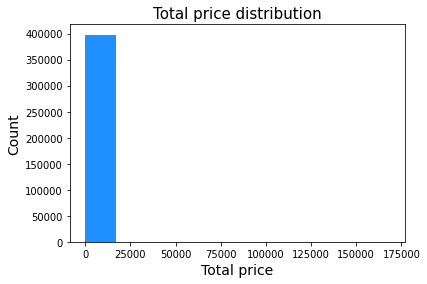

In [ ]:
plt.hist(data=df, x="TotalPrice", color="dodgerblue")
plt.xlabel("Total price", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Total price distribution", fontsize=15)

In [ ]:
df["TotalPrice"].describe(percentiles=[.99])

count    397885.000000
mean         22.396989
std         309.070653
min           0.001000
50%          11.800000
99%         202.500000
max      168469.600000
Name: TotalPrice, dtype: float64

Text(0.5, 1.0, 'Distribution of quantity of products')

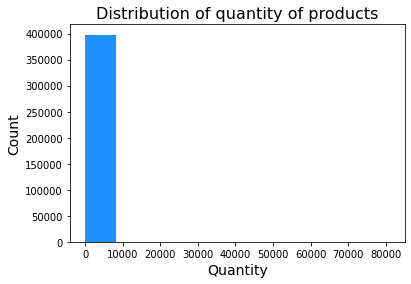

In [ ]:
plt.hist(data=df, x='Quantity', color='dodgerblue')
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of quantity of products", fontsize=16)

In [ ]:
df['Quantity'].describe(percentiles=[.99])

count    397885.000000
mean         12.988208
std         179.331551
min           1.000000
50%           6.000000
99%         120.000000
max       80995.000000
Name: Quantity, dtype: float64

Text(0.5, 1.0, 'Distribution of quantity of products')

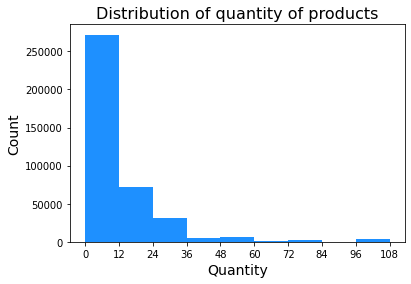

In [ ]:
bins = np.arange(0,120,12)
ticks =np.arange(0,120,12)

plt.hist(data=df, x="Quantity",bins=bins, color="dodgerblue")
plt.xticks(ticks,ticks)
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of quantity of products", fontsize=16)

In [ ]:
#Keşfedici Veri Analizi

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days / x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [ ]:
df_orders = df.groupby(['Customer ID', 'Invoice']).agg({'TotalPrice': sum, 'InvoiceDate': max})

In [ ]:
df_orders.head()

TotalPrice         InvoiceDate
Customer ID Invoice                                
12346.0     541431     77183.60 2011-01-18 10:01:00
12347.0     537626       711.79 2010-12-07 14:57:00
            542237       475.39 2011-01-26 14:30:00
            549222       636.25 2011-04-07 10:43:00
            556201       382.52 2011-06-09 13:01:00

In [ ]:
df_orders['InvoiceDate'].max(), df_orders['InvoiceDate'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
df_summary = df_orders.reset_index().groupby('Customer ID').agg({
            'TotalPrice': [min, max, sum, groupby_mean, groupby_count],
            'InvoiceDate': [min, max, purchase_duration, avg_frequency]
             })

In [ ]:
df_summary.head()

TotalPrice            ...       InvoiceDate                   
                   min       max  ... purchase_duration purchase_frequency
Customer ID                       ...                                     
12346.0       77183.60  77183.60  ...                 0           0.000000
12347.0         224.82   1294.32  ...               365          52.142857
12348.0         227.44    892.80  ...               282          70.500000
12349.0        1757.55   1757.55  ...                 0           0.000000
12350.0         334.40    334.40  ...                 0           0.000000

[5 rows x 9 columns]

In [ ]:
df_summary.columns = ['_'.join(col).lower() for col in df_summary.columns]

In [ ]:
df_summary

,totalprice_min,totalprice_max,totalprice_sum,totalprice_avg,totalprice_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
Customer ID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000
12347.0,224.82,1294.32,4310.00,615.714286,7.0,2010-12-07 14:57:00,2011-12-07 15:52:00,365,52.142857
12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1757.55,1757.55,1757.55,1757.550000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,334.40,334.40,334.40,334.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
...,...,...,...,...,...,...,...,...,...
18280.0,180.60,180.60,180.60,180.600000,1.0,2011-03-07 09:52:00,2011-03-07 09:52:00,0,0.000000
18281.0,80.82,80.82,80.82,80.820000,1.0,2011-06-12 10:53:00,2011-06-12 10:53:00,0,0.000000
18282.0,77.84,100.21,178.05,89.025000,2.0,2011-08-05 13:35:00,2011-12-02 11:43:00,118,59.000000


In [ ]:
# purchase_duration 'ı 0 dan büyük alanları dikkate alalım

df_summary = df_summary[df_summary['invoicedate_purchase_duration'] > 0]

In [ ]:
df_summary.shape

(2783, 9)

Text(0.5, 1.0, 'Number of Purchases')

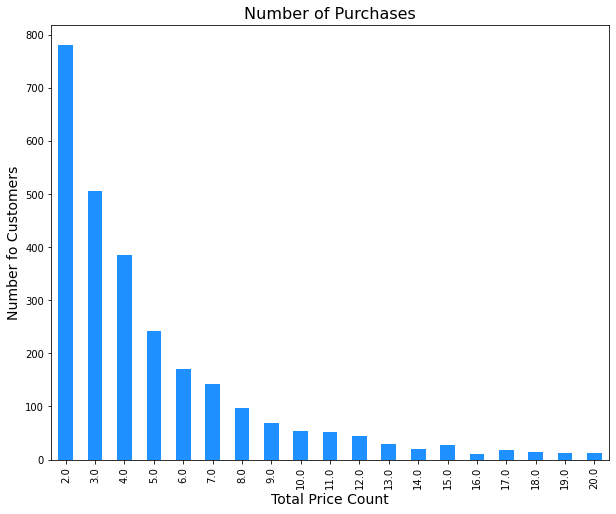

In [ ]:
# Number of purchases

ax=df_summary.groupby('totalprice_count').count()['totalprice_avg'][:20].plot(
    kind="bar",
    color="dodgerblue",
    figsize=(10,8),
    grid=False)
plt.xlabel("Total Price Count", fontsize=14)
plt.ylabel("Number fo Customers", fontsize=14)
plt.title("Number of Purchases", fontsize=16)

Text(0.5, 1.0, 'Frequency  of Purchases')

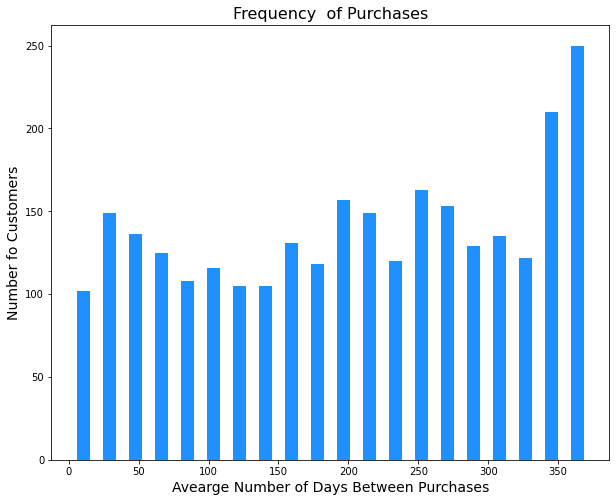

In [ ]:
# Average number of days between purchases

ax = df_summary['invoicedate_purchase_duration'].hist(
    bins=20,
    color="dodgerblue",
    rwidth=0.5,
    figsize=(10,8),
    grid=False)
plt.xlabel("Avearge Number of Days Between Purchases", fontsize=14)
plt.ylabel("Number fo Customers", fontsize=14)
plt.title("Frequency  of Purchases", fontsize=16)

In [13]:
# outlinerlar için alt ve üst sınırları basklıyacak fonksyinoları yazalım

def outliner_thresholds(dataframe,variable):
  quartile1 = dataframe[variable].quantile(0.01)
  quartile3 = dataframe[variable].quantile(0.99)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit,up_limit

def replace_with_thresholds(dataframe,variable):
  low_limit,up_limit = outliner_thresholds(dataframe,variable)
  dataframe.loc[(dataframe[variable] < low_limit),variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit),variable] = up_limit

In [14]:
replace_with_thresholds(df,"Quantity")
replace_with_thresholds(df,"Price")

In [15]:
df["TotalPrice"]= df["Quantity"] * df["Price"]

In [16]:
df_UK = df[df["Country"] == "United Kingdom"]

In [17]:
df_UK.shape

(354321, 9)

In [ ]:
LifeTime_VeriSetinin_Hazırlanışı

In [18]:
today_date = dt.datetime(2011,12,11)

In [ ]:
# recency, T(custormer's age), frequency, monetary_value değerlerini hesaplayalım

#recency : En son satış ile ilk satış arasındaki gün sayısı

# T:müşterinin yaşı,yani analiz tarihimizinden müşterinin ilk alışveriş tarihini çıkartarak satın almaya göre müşteri yaşı

# frequency = müşteri bazında unique fatura sayısı

#monetary_value = müşterinin harcadığı toplam tutar olarak hesaplatalım, daha sonra buradan monetary değerini bulacağız

In [19]:
cltv_df = df_UK.groupby('Customer ID').agg({'InvoiceDate':[lambda date: (date.max() - date.min()).days,
                                                           lambda date: (today_date - date.min()).days],
                                            'Invoice': lambda num: num.nunique(),
                                            'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [20]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0               0        326        1     310.44
12747.0             366        370       11    4196.01
12748.0             372        374      209   32380.41
12749.0             209        214        5    4077.94
12820.0             323        327        4     942.34

In [ ]:
# Kolon adlarını lambda ile oluşturduğumuz için düzenlemeliyiz

In [21]:
# Edit the index
cltv_df.columns = cltv_df.columns.droplevel(0)
#Yukarıdaki sorgu agg fonksiyonu içindeki ana kolon adlarını siler

In [22]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,0,326,1,310.44
12747.0,366,370,11,4196.01
12748.0,372,374,209,32380.41
12749.0,209,214,5,4077.94
12820.0,323,327,4,942.34


In [23]:
#Değişken adları

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [ ]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,326,1,310.44
12747.0,366,370,11,4196.01
12748.0,372,374,209,32380.41
12749.0,209,214,5,4077.94
12820.0,323,327,4,942.34


In [24]:
# frequency 1 den büyük ve satın alma toplam tutarı 0'dan büyük olan veriler ile çalışacağız

cltv_df=cltv_df[cltv_df['frequency'] > 1]

In [25]:
cltv_df=cltv_df[cltv_df['monetary'] > 0]

In [26]:
# monetary değeri satın alma başına ortalama kazanç olarak dikkate alıyoruz

cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']

In [27]:
# recency ve T değerini haftalık olarak ele alıyoruz

cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['T'] = cltv_df['T'] / 7

In [ ]:
Modellerin Kurulması

In [28]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [29]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

In [30]:
# Who are the 10 customers we expect the most to purchase in a week?

cltv_df["expected_purc_1_week"]= bgf.predict(1,
                                             cltv_df["frequency"],
                                             cltv_df["recency"],
                                             cltv_df["T"]).sort_values(ascending=False)

In [31]:
cltv_df['expected_purc_1_week'].sort_values(ascending=False).head(10)

Customer ID
12748.0    3.237513
17841.0    1.933188
13089.0    1.531968
14606.0    1.458749
15311.0    1.428578
12971.0    1.352222
13408.0    0.982882
18102.0    0.965260
13798.0    0.908210
14527.0    0.882931
Name: expected_purc_1_week, dtype: float64

In [32]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                cltv_df['frequency'],
                                                cltv_df['recency'],
                                                cltv_df['T'])

In [33]:
cltv_df['expected_purc_1_month'].sort_values(ascending=False).head(10)

Customer ID
12748.0    12.915924
17841.0     7.712335
13089.0     6.111536
14606.0     5.819567
15311.0     5.699201
12971.0     5.394550
13408.0     3.921105
18102.0     3.850665
13798.0     3.623181
14527.0     3.522267
Name: expected_purc_1_month, dtype: float64

In [34]:
# What is the Expected Number of Sales of the Whole Company in 1 Month?

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1597.1128041108107

In [35]:
# What is the Expected Number of Sales of the Whole Company in 3 Months?

bgf.predict(4*3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

4738.529818520041

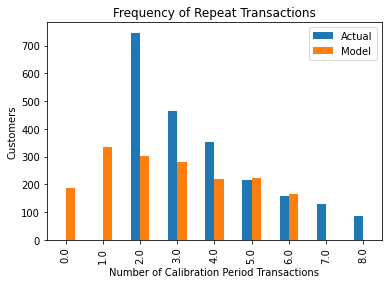

In [ ]:
# Evaluation of Forecast Results

plot_period_transactions(bgf)
plt.show()

In [36]:
# Satın alma davranışlarının farklılığı incelenirken Gamma dağılımından yararlanılır

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.81, q: 0.35, v: 3.75>

In [37]:
#Expected_avarage_profit

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
14088.0    3916.384282
18102.0    3870.838975
15749.0    3213.278097
14096.0    3195.972563
17511.0    2950.346629
17450.0    2874.045685
13081.0    2617.171732
16000.0    2477.667281
16984.0    2452.328358
16684.0    2223.690179
dtype: float64

In [38]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [39]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12747.0,52.285714,52.857143,11,381.455455,0.202475,0.807661,387.828217
12748.0,53.142857,53.428571,209,154.930191,3.237513,12.915924,155.075070
12749.0,29.857143,30.571429,5,815.588000,0.167144,0.665709,845.260081
12820.0,46.142857,46.714286,4,235.585000,0.103970,0.414561,247.090547
12822.0,2.285714,12.571429,2,474.440000,0.129143,0.512661,520.871050


In [40]:
# Calculate CLTV with Gamma-Gamma Model and BG-NBD

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # 6 monthly
                                   freq="W",  # T: frequency
                                   discount_rate=0.01)

In [41]:
cltv.head()

Customer ID
12747.0     1937.035263
12748.0    12395.361541
12749.0     3450.677900
12820.0      631.958064
12822.0     1612.262384
Name: clv, dtype: float64

In [ ]:
cltv.shape

(2570,)

In [42]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
2486,18102.0,92215.233584
589,14096.0,55726.778046
2184,17450.0,52846.107624
2213,17511.0,36947.207911
1804,16684.0,26146.294267
406,13694.0,25224.934931
587,14088.0,25041.839323
1485,16000.0,23975.522233
1173,15311.0,23597.164785
133,13089.0,22971.583929


In [43]:
cltv_final = cltv_df.merge(cltv, on ="Customer ID", how="left")

In [44]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2486,18102.0,52.285714,52.571429,60,3859.739083,0.965260,3.850665,3870.838975,92215.233584
589,14096.0,13.857143,14.571429,17,3163.588235,0.722998,2.873329,3195.972563,55726.778046
2184,17450.0,51.285714,52.571429,46,2863.274891,0.745052,2.972181,2874.045685,52846.107624
2213,17511.0,52.857143,53.428571,31,2933.943065,0.507359,2.024010,2950.346629,36947.207911
1804,16684.0,50.428571,51.285714,28,2209.969107,0.476669,1.901401,2223.690179,26146.294267
406,13694.0,52.714286,53.428571,50,1275.700500,0.798225,3.184419,1280.155796,25224.934931
587,14088.0,44.571429,46.142857,13,3864.554615,0.259725,1.035722,3916.384282,25041.839323
1485,16000.0,0.000000,0.428571,3,2335.120000,0.415948,1.640698,2477.667281,23975.522233
1173,15311.0,53.285714,53.428571,91,667.779121,1.428578,5.699201,669.078222,23597.164785
133,13089.0,52.285714,52.857143,97,606.362474,1.531968,6.111536,607.472561,22971.583929


In [45]:
# CLV değerlerini standartlaştırarak kategorize edelim
scaler = MinMaxScaler(feature_range=(1, 100))

scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

In [46]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv
0,12747.0,52.285714,52.857143,11,381.455455,0.202475,0.807661,387.828217,1937.035263,3.079553
1,12748.0,53.142857,53.428571,209,154.930191,3.237513,12.915924,155.075070,12395.361541,14.307354
2,12749.0,29.857143,30.571429,5,815.588000,0.167144,0.665709,845.260081,3450.677900,4.704563
3,12820.0,46.142857,46.714286,4,235.585000,0.103970,0.414561,247.090547,631.958064,1.678455
4,12822.0,2.285714,12.571429,2,474.440000,0.129143,0.512661,520.871050,1612.262384,2.730885


In [47]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [48]:
cltv_final["segment"].value_counts()

A    643
D    643
B    642
C    642
Name: segment, dtype: int64

In [49]:
cltv_final.groupby("segment").agg({"clv":["sum","mean","min","max","count"]})

clv                                               
                  sum         mean           min           max count
segment                                                             
D        1.739652e+05   270.552438  9.316331e-22    498.371960   643
C        4.574626e+05   712.558529  4.988086e+02    954.201653   642
B        8.180803e+05  1274.268363  9.549220e+02   1705.502793   642
A        2.477739e+06  3853.404346  1.705760e+03  92215.233584   643

In [50]:
cltv_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2570 entries, 0 to 2569
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Customer ID              2570 non-null   float64 
 1   recency                  2570 non-null   float64 
 2   T                        2570 non-null   float64 
 3   frequency                2570 non-null   int64   
 4   monetary                 2570 non-null   float64 
 5   expected_purc_1_week     2570 non-null   float64 
 6   expected_purc_1_month    2570 non-null   float64 
 7   expected_average_profit  2570 non-null   float64 
 8   clv                      2570 non-null   float64 
 9   scaled_clv               2570 non-null   float64 
 10  segment                  2570 non-null   category
dtypes: category(1), float64(9), int64(1)
memory usage: 303.6 KB


In [ ]:
 # Submitting Results to Database

cltv_final = cltv_final.reset_index()
cltv_final["Customer ID"] = cltv_final["Customer ID"].astype(int)

In [62]:
cltv_final=cltv_final.iloc[:,1:]
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv,segment
0,12747,52.285714,52.857143,11,381.455455,0.202475,0.807661,387.828217,1937.035263,3.079553,A
1,12748,53.142857,53.428571,209,154.930191,3.237513,12.915924,155.075070,12395.361541,14.307354,A
2,12749,29.857143,30.571429,5,815.588000,0.167144,0.665709,845.260081,3450.677900,4.704563,A
3,12820,46.142857,46.714286,4,235.585000,0.103970,0.414561,247.090547,631.958064,1.678455,C
4,12822,2.285714,12.571429,2,474.440000,0.129143,0.512661,520.871050,1612.262384,2.730885,B


In [65]:
# let’s create a schema
from sqlalchemy.types import *

In [67]:
df_schema = {
"Customer ID": Integer, 
"recency": Float,
"T": Float,
"frequency": Integer,
"monetary": DECIMAL(15,4),
"expected_purc_1_week": Float,
"expected_purc_1_month": Float,
"expected_average_profit": Float,
"clv": Float,
"scaled_clv": Float,
"segment": String(2)
}

In [ ]:
cltv_final.to_sql(name="Baris_Dal",con =conn,if_exists = 'replace',index = False, dtype=df_schema)
pd.read_sql_query("show tables",conn)
conn.close()